# Assignment 1 - Part 2: Traffic Sign Classification with PyTorch (Fixed Version)

This notebook implements traffic sign classification using the GTSRB dataset with PyTorch. It includes several improvements and fixes over a basic implementation:
- Removed unnecessary `softmax` layer from the model (since `nn.CrossEntropyLoss` handles it internally).
- Increased model capacity with more convolutional filters.
- Switched to the Adam optimizer for better convergence.
- Adjusted data augmentation to preserve critical image details.
- Increased batch size to 64 for more stable training.
- Extended training to 20 epochs for better learning.

## Table of Contents
1. **Load and Visualize the Dataset**
2. **Preprocess Data with Augmentation**
3. **Define the CNN Model (Fixed)**
4. **Train and Monitor the Model (Improved)**
5. **Compare Gradient Methods and Learning Rate Schedules**

---




## 1. Load and Visualize the Dataset

We load the GTSRB dataset, split it into training (95%), validation (5%), and test sets, and visualize 10 random training images to understand the data.

100%|██████████| 187M/187M [00:07<00:00, 25.4MB/s]
100%|██████████| 89.0M/89.0M [00:04<00:00, 21.9MB/s]
100%|██████████| 99.6k/99.6k [00:00<00:00, 298kB/s]


Training set size: 25308
Validation set size: 1332
Test set size: 12630


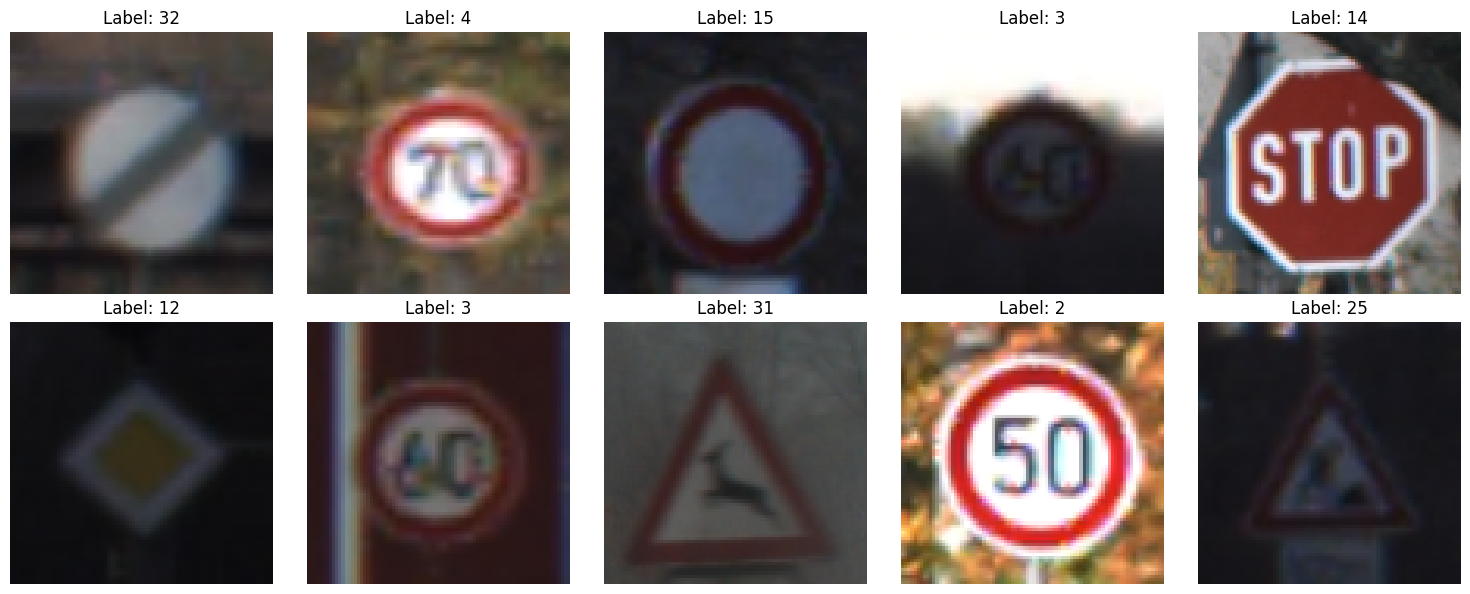

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import random_split, DataLoader
import matplotlib.pyplot as plt
import random

# Set random seed for reproducibility
torch.manual_seed(42)
random.seed(42)

# Define base transforms (no augmentation yet)
base_transforms = transforms.Compose([
    transforms.Resize((84, 84)),  # Resize to 84x84
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load the full training and test datasets
train_dataset_full = torchvision.datasets.GTSRB(root='./data', split='train', transform=base_transforms, download=True)
test_dataset = torchvision.datasets.GTSRB(root='./data', split='test', transform=base_transforms, download=True)

# Split training dataset: 5% for validation
val_size = int(0.05 * len(train_dataset_full))
train_size = len(train_dataset_full) - val_size
train_dataset, val_dataset = random_split(train_dataset_full, [train_size, val_size])

print(f"Training set size: {len(train_dataset)}")
print(f"Validation set size: {len(val_dataset)}")
print(f"Test set size: {len(test_dataset)}")

# Visualize 10 random training images
indices = random.sample(range(len(train_dataset)), 10)
images = [train_dataset[i][0] for i in indices]
labels = [train_dataset[i][1] for i in indices]

# Function to unnormalize and convert tensor to image
def imshow(img, title):
    img = img * torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1) + torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    img = img.numpy().transpose((1, 2, 0))
    plt.imshow(img.clip(0, 1))
    plt.title(title)
    plt.axis('off')

plt.figure(figsize=(15, 6))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    imshow(images[i], f'Label: {labels[i]}')
plt.tight_layout()
plt.show()

## 2. Preprocess Data with Augmentation

We apply data augmentation to the training set to improve model robustness. Augmentations include rotation, color variation, and a less aggressive crop (80%-100% of the image area). We visualize the images before and after augmentation.


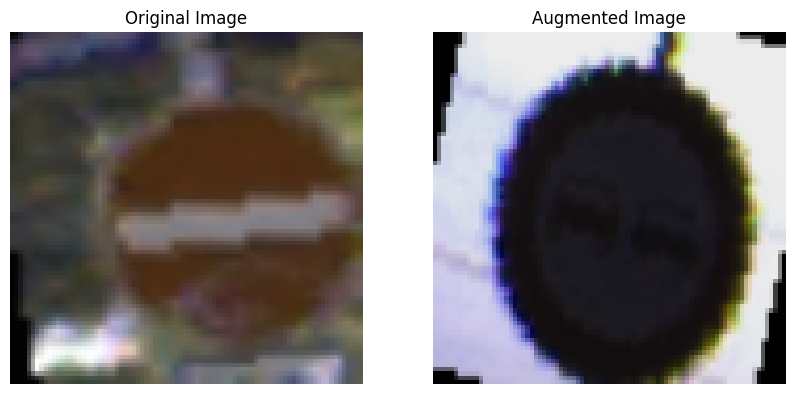

In [2]:
# Define augmentation transforms for training
train_transforms = transforms.Compose([
    transforms.RandomRotation(15),  # Rotate by ±15 degrees
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),  # Color variation
    transforms.RandomResizedCrop(size=(84, 84), scale=(0.8, 1.0)),  # Crop between 80% and 100% of area
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Apply augmentation to the training dataset
train_dataset.dataset.transform = train_transforms

# Visualize before and after augmentation
sample_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
original_loader = DataLoader(random_split(train_dataset_full, [1, len(train_dataset_full)-1])[0], batch_size=1)

original_img, label = next(iter(original_loader))
augmented_img, _ = next(iter(sample_loader))

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
imshow(original_img[0], "Original Image")
plt.subplot(1, 2, 2)
imshow(augmented_img[0], "Augmented Image")
plt.show()

## 3. Define the CNN Model (Fixed)

We define a convolutional neural network (CNN) with increased capacity (32 and 64 filters) and no `softmax` layer, as `nn.CrossEntropyLoss` expects raw logits. The architecture is:
- Input (3x84x84) → Conv (32 filters) → ReLU → Conv (32 filters) → MaxPool → Conv (64 filters) → ReLU → Conv (64 filters) → MaxPool → FC (128 units) → FC (43 classes).


In [3]:
import torch.nn as nn

class TrafficSignCNN(nn.Module):
    def __init__(self):
        super(TrafficSignCNN, self).__init__()
        self.conv_1_1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)  # 84x84x3 -> 84x84x32
        self.relu_1_1 = nn.ReLU()
        self.conv_1_2 = nn.Conv2d(32, 32, kernel_size=3, padding=1)  # 84x84x32 -> 84x84x32
        self.max_pool_1 = nn.MaxPool2d(kernel_size=2, stride=2)     # 84x84x32 -> 42x42x32
        self.conv_2_1 = nn.Conv2d(32, 64, kernel_size=3, padding=1)  # 42x42x32 -> 42x42x64
        self.relu_2_1 = nn.ReLU()
        self.conv_2_2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)  # 42x42x64 -> 42x42x64
        self.max_pool_2 = nn.MaxPool2d(kernel_size=2, stride=2)     # 42x42x64 -> 21x21x64
        self.fc_1 = nn.Linear(64 * 21 * 21, 128)  # 21x21x64 = 28224 -> 128
        self.fc_2 = nn.Linear(128, 43)  # 43 classes

    def forward(self, x):
        x = self.conv_1_1(x)
        x = self.relu_1_1(x)
        x = self.conv_1_2(x)
        x = self.max_pool_1(x)
        x = self.conv_2_1(x)
        x = self.relu_2_1(x)
        x = self.conv_2_2(x)
        x = self.max_pool_2(x)
        x = x.view(-1, 64 * 21 * 21)
        x = self.fc_1(x)
        x = self.fc_2(x)
        return x  # Raw logits

# Instantiate the model
model = TrafficSignCNN()
print(model)

TrafficSignCNN(
  (conv_1_1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu_1_1): ReLU()
  (conv_1_2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (max_pool_1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv_2_1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu_2_1): ReLU()
  (conv_2_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (max_pool_2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc_1): Linear(in_features=28224, out_features=128, bias=True)
  (fc_2): Linear(in_features=128, out_features=43, bias=True)
)


## 4. Train and Monitor the Model (Improved)

We train the model using the Adam optimizer (learning rate 0.001), a batch size of 64, and 20 epochs. Training progress is monitored with plots of loss and accuracy for both training and validation sets.


Epoch 1/20, Train Loss: 0.8495, Val Loss: 0.8040, Train Acc: 73.60%, Val Acc: 73.27%
Epoch 2/20, Train Loss: 0.7395, Val Loss: 0.7172, Train Acc: 76.95%, Val Acc: 76.88%
Epoch 3/20, Train Loss: 0.6984, Val Loss: 0.7264, Train Acc: 78.25%, Val Acc: 76.88%
Epoch 4/20, Train Loss: 0.6566, Val Loss: 0.6266, Train Acc: 79.70%, Val Acc: 80.63%
Epoch 5/20, Train Loss: 0.6162, Val Loss: 0.6253, Train Acc: 80.66%, Val Acc: 80.86%
Epoch 6/20, Train Loss: 0.5901, Val Loss: 0.6113, Train Acc: 81.79%, Val Acc: 80.03%
Epoch 7/20, Train Loss: 0.5604, Val Loss: 0.5613, Train Acc: 82.86%, Val Acc: 82.51%
Epoch 8/20, Train Loss: 0.5396, Val Loss: 0.5577, Train Acc: 83.21%, Val Acc: 84.46%
Epoch 9/20, Train Loss: 0.5216, Val Loss: 0.5063, Train Acc: 84.13%, Val Acc: 85.14%
Epoch 10/20, Train Loss: 0.4965, Val Loss: 0.4838, Train Acc: 84.95%, Val Acc: 83.56%
Epoch 11/20, Train Loss: 0.4813, Val Loss: 0.4762, Train Acc: 85.40%, Val Acc: 84.61%
Epoch 12/20, Train Loss: 0.4665, Val Loss: 0.4467, Train Acc: 8

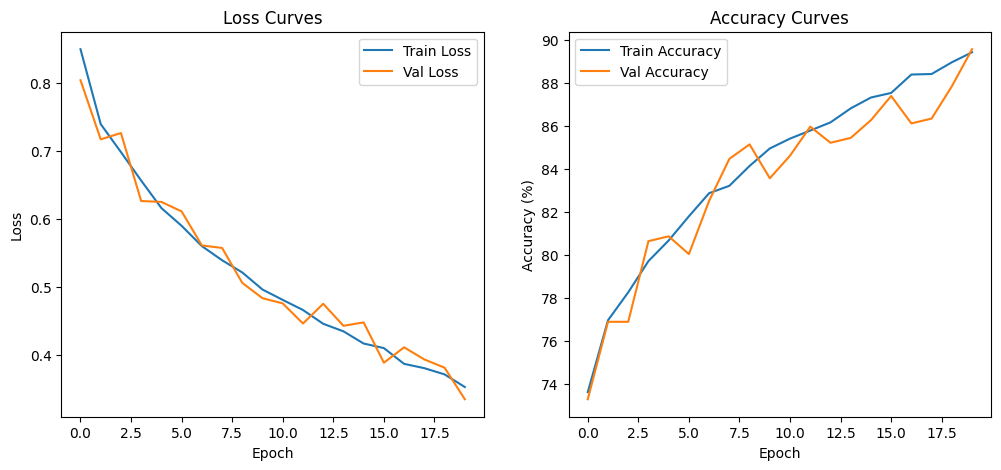

In [5]:
from torch.utils.data import DataLoader
import torch.optim as optim

# DataLoaders with batch size 64
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Loss and optimizer (SGD with lr=0.001)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.6)

# Training function
def train_model(model, train_loader, val_loader, epochs=20):
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    for epoch in range(epochs):
        # Training
        model.train()
        train_loss, correct, total = 0, 0, 0
        for images, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_losses.append(train_loss / len(train_loader))
        train_accuracies.append(100 * correct / total)

        # Validation
        model.eval()
        val_loss, correct, total = 0, 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                outputs = model(images)
                val_loss += criterion(outputs, labels).item()
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_losses.append(val_loss / len(val_loader))
        val_accuracies.append(100 * correct / total)

        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}, "
              f"Train Acc: {train_accuracies[-1]:.2f}%, Val Acc: {val_accuracies[-1]:.2f}%")

    return train_losses, val_losses, train_accuracies, val_accuracies

# Train the model
train_losses, val_losses, train_accuracies, val_accuracies = train_model(model, train_loader, val_loader)



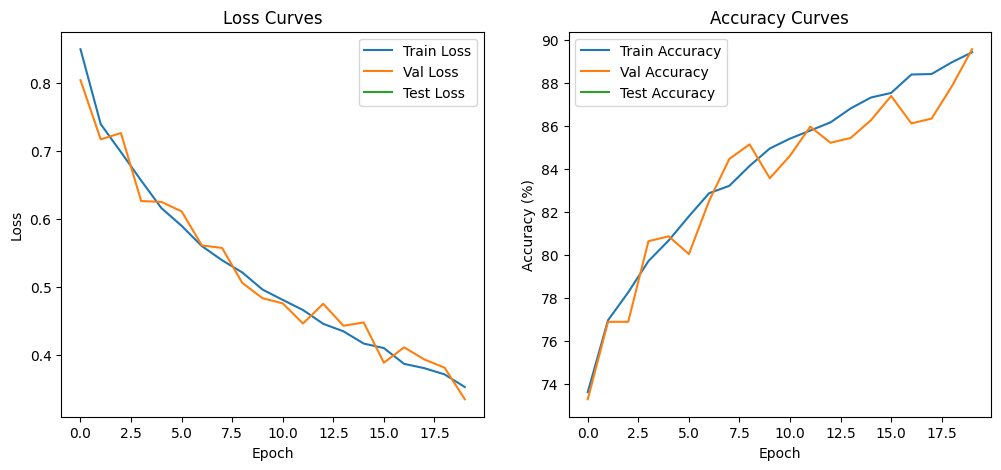

In [11]:
# Plotting
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Curves')

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Val Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.title('Accuracy Curves')
plt.show()

In [14]:
def test_model(model, test_loader):
    model.eval()  # Evaluation mode
    test_losses, test_accuracies = [], []
    test_loss, correct, total = 0, 0, 0
    with torch.no_grad():
            for images, labels in test_loader:
                outputs = model(images)
                test_loss += criterion(outputs, labels).item()
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

    test_losses.append(test_loss / len(test_loader))
    test_accuracies.append(100 * correct / total)
    return test_accuracies, test_losses

# Test
test_accuracies, test_losses = test_model(model, test_loader)
print(f"Test Accuracy: {test_accuracies[-1]:.2f}%, Test Loss: {test_losses[-1]:.4f}")



Test Accuracy: 86.02%, Test Loss: 0.4999


## 5. Compare Gradient Methods and Learning Rate Schedules

### 5a. Compare Gradient Methods
We compare the performance of the model using SGD and Adam optimizers.

### 5b. Compare Learning Rate Schedules
We implement a StepLR scheduler and compare the training process with and without it.


In [19]:
# 5a. Compare with Adam optimizer
model_adam = TrafficSignCNN()
optimizer = optim.Adam(model_adam.parameters(), lr=0.001)
train_losses_adam, val_losses_adam, train_accuracies_adam, val_accuracies_adam = train_model(model_adam, train_loader, val_loader)

Epoch 1/20, Train Loss: 1.1474, Val Loss: 0.4391, Train Acc: 66.41%, Val Acc: 85.74%


KeyboardInterrupt: 

In [ ]:
# 5b. Implement learning rate scheduler (StepLR)
model_scheduler = TrafficSignCNN()
optimizer_scheduler = optim.SGD(model_scheduler.parameters(), lr=0.01, momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer_scheduler, step_size=5, gamma=0.1)

def train_model_with_scheduler(model, train_loader, val_loader, optimizer, scheduler, epochs=20):
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []
    for epoch in range(epochs):
        model.train()
        train_loss, correct, total = 0, 0, 0
        for images, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        scheduler.step()  # Update learning rate

        train_losses.append(train_loss / len(train_loader))
        train_accuracies.append(100 * correct / total)

        model.eval()
        val_loss, correct, total = 0, 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                outputs = model(images)
                val_loss += criterion(outputs, labels).item()
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_losses.append(val_loss / len(val_loader))
        val_accuracies.append(100 * correct / total)

        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}, "
              f"Train Acc: {train_accuracies[-1]:.2f}%, Val Acc: {val_accuracies[-1]:.2f}%")

    return train_losses, val_losses, train_accuracies, val_accuracies

# Train with scheduler
train_losses_sched, val_losses_sched, train_accuracies_sched, val_accuracies_sched = train_model_with_scheduler(model_scheduler, train_loader, val_loader, optimizer_scheduler, scheduler)



Epoch 1/20, Train Loss: 1.5865, Val Loss: 0.7806, Train Acc: 54.27%, Val Acc: 75.68%


In [ ]:
# Test
test_adam_accuracies, test_adam_losses = test_model(model_adam, test_loader)
print(f"Test Accuracy for Adam: {test_adam_accuracies[-1]:.2f}%, Test Loss: {test_adam_losses[-1]:.4f}")

test_scheduler_accuracies, test_scheduler_losses = test_model(model_scheduler, test_loader)
print(f"Test Accuracy for Scheduler: {test_scheduler_accuracies[-1]:.2f}%, Test Loss: {test_scheduler_losses[-1]:.4f}")

# Plot comparisons
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='SGD Train Loss')
plt.plot(train_losses_adam, label='Adam Train Loss')
plt.plot(train_losses_sched, label='SGD with Scheduler Train Loss')
plt.legend()
plt.title('Training Loss Comparison')

plt.subplot(1, 2, 2)
plt.plot(val_accuracies, label='SGD Val Accuracy')
plt.plot(val_accuracies_adam, label='Adam Val Accuracy')
plt.plot(val_accuracies_sched, label='SGD with Scheduler Val Accuracy')
plt.legend()
plt.title('Validation Accuracy Comparison')
plt.show()

## Conclusion

This notebook demonstrates the complete process of building, training, and evaluating a CNN for traffic sign classification using the GTSRB dataset. It includes data loading, augmentation, model definition, training with monitoring, and comparisons of optimization techniques. The visualizations and results provide insights into the model's performance.
